# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

In [1]:
!mv pc.csv pittscrime.csv

In [2]:
!wc -l pittscrime.csv

117718 pittscrime.csv


In [3]:
!csvcut -n pittscrime.csv

  1: _id
  2: REPORT_NAME
  3: CCR
  4: SECTION
  5: DESCRIPTION
  6: ARREST_TIME
  7: ADDRESS
  8: NEIGHBORHOOD
  9: ZONE
 10: AGE
 11: GENDER


What do columns mean?

https://data.wprdc.org/dataset/pittsburgh-police-incident-blotter
1. _id: The identification number for the each crime
2. Report_name: The name of each crime report, such as arrest or offense
3. ccr: CCR is the Central Control Record number. It is a reference number or unique identifier for a report.
4. Section: The identification number for the crime report
5. Description: The detailed explanation of each crime
6. Arrest_time: The arrest time in the format of Year-month-dayTime.
7. Address: The detailed address of the crime occured, e.g., 4th Ave & Delray St
8. Neighborhood: The neighborhood which the address belongs to, e.g., Shadyside
9. Zone: The zone number of the neighborhood belongs to
10. Age: The age of the criminal
11. Gender: The gender of the criminal

In [4]:
!shuf -n 1000 pittscrime.csv | csvstat 


  1. 40885
	<class 'int'>
	Nulls: False
	Min: 232
	Max: 117623
	Sum: 58527240
	Mean: 58585.82582582583
	Median: 59403
	Standard Deviation: 34424.08390162563
	Unique values: 999
  2. OFFENSE 2.0
	<class 'str'>
	Nulls: True
	Values: OFFENSE 2.0, ARREST
  3. 15116766
	<class 'int'>
	Nulls: False
	Min: 12056165
	Max: 16208891
	Sum: 15593654357
	Mean: 15609263.620620621
	Median: 15247303
	Standard Deviation: 510442.60463610897
	Unique values: 986
	5 most frequent values:
		16203645:	3
		16081989:	2
		16008177:	2
		16201804:	2
		16138457:	2
  4. 5503
	<class 'str'>
	Nulls: False
	Unique values: 158
	5 most frequent values:
		3304:	60
		13(a)(16):	45
		2701:	42
		3921:	37
		9999:	34
	Max length: 17
  5. Disorderly Conduct.
	<class 'str'>
	Nulls: False
	Unique values: 165
	5 most frequent values:
		Criminal Mischief.:	60
		Possession of Controlled Substance:	45
		Simple Assault.:	42
		Theft by Unlawful Taking or Disposition.:	37
		Aggravated Assault.:	32
	Max length: 121
  6. 2015-06-26T19:05:

Are there null values?

Yes. There are 4 columns have null values(C2 C9 C10 C11). They are Report_name, Zone, Age and Gender.

In [5]:
!head pittscrime.csv|csvlook

|--------+-------------+----------+---------+----------------------------------------------------+---------------------+------------------------+------------------+------+-----+---------|
|  _id   | REPORT_NAME | CCR      | SECTION | DESCRIPTION                                        | ARREST_TIME         | ADDRESS                | NEIGHBORHOOD     | ZONE | AGE | GENDER  |
|--------+-------------+----------+---------+----------------------------------------------------+---------------------+------------------------+------------------+------+-----+---------|
|  53961 | OFFENSE 2.0 | 15158500 | 903     | Criminal Conspiracy.                               | 2015-08-22T23:59:00 | 400 block East Commons | Allegheny Center | 1    |     |         |
|  53962 | OFFENSE 2.0 | 15158500 | 6106    | Firearms not to be Carried without a License.      | 2015-08-22T23:59:00 | 400 block East Commons | Allegheny Center | 1    |     |         |
|  53963 | OFFENSE 2.0 | 15158500 | 3925    | Receiving Stol

We are particularly inerested in the location of the crime, which includes columns "Address", "Neighborhood" and "Zone". The location information could tell us the frequency of crime happening on each part of the Greater Pittsburgh area. Therefore I could do analysis on identifying the degree of safety on each area and help residents avoid the dangerous area. The questions I could ask includes but not limited to:
1. Which neighborhoods have the least frequecy of crime?
2. what type of crime happened most frequently?
3. What are the safe place that we could suggest to live?
4. What are the area that the policy should pay more attention to in order to decrease the crime rate?

## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

This step is to restart PostgreSQL.

In [6]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


Then we create a database named pro2.

In [7]:
!createdb -U dbuser pittscrime

This step is to load sql extension.

In [8]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


This show we connect to the database successfully.

In [9]:
%sql postgresql://dbuser@localhost:5432/pittscrime

'Connected: dbuser@pittscrime'

In [10]:
%%sql
DROP TABLE IF EXISTS pittscrime;
CREATE TABLE pittscrime
(
    id INTEGER,
    REPORT_NAME VARCHAR(11),
    CCR INTEGER,
    SECTION VARCHAR(19),
    DESCRIPTION VARCHAR(128),
    ARREST_TIME TIMESTAMP,
    ADDRESS VARCHAR(53), 
    NEIGHBORHOOD VARCHAR(27),
    ZONE INTEGER, 
    AGE INTEGER, 
    GENDER VARCHAR(4)
)


Done.
Done.


[]

In [11]:
!pwd

/home/jovyan/work


In [12]:
%%sql
COPY pittscrime FROM '/home/jovyan/work/pittscrime.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

117717 rows affected.


[]

In [13]:
%%sql
SELECT COUNT(*)
FROM pittscrime;

1 rows affected.


count
117717


Now we are going to explore more about the crime data. We are particularly interested in the Crime rate at different neighborhood. So we count the cime frequency of each neighborhood first.

In [14]:
%%sql
SELECT DISTINCT neighborhood, COUNT(*) as Count
FROM pittscrime
GROUP BY neighborhood
ORDER BY Count DESC
LIMIT 20;

20 rows affected.


neighborhood,count
Golden Triangle/Civic Arena,8229
South Side Flats,7645
East Liberty,3503
East Allegheny,3499
Carrick,3402
Brighton Heights,2665
Sheraden,2569
Bluff,2559
Marshall-Shadeland,2520
Mount Washington,2510


The above table gives the top 20 neighborhoods with the highest crime rate. Golden Triangle/Civic Arena, South Side Flats and East Liberty are the most danagerous neighborhoods.

In [15]:
%%sql
SELECT DISTINCT neighborhood, COUNT(*) as Count
FROM pittscrime
GROUP BY neighborhood
ORDER BY Count DESC
LIMIT 20

20 rows affected.


neighborhood,count
Golden Triangle/Civic Arena,8229
South Side Flats,7645
East Liberty,3503
East Allegheny,3499
Carrick,3402
Brighton Heights,2665
Sheraden,2569
Bluff,2559
Marshall-Shadeland,2520
Mount Washington,2510


The above table gives the top 20 neighborhoods with the highest crime rate. Golden Triangle/Civic Arena, South Side Flats and East Liberty are the most danagerous neighborhoods.

In [16]:
import matplotlib
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<Container object of 20 artists>

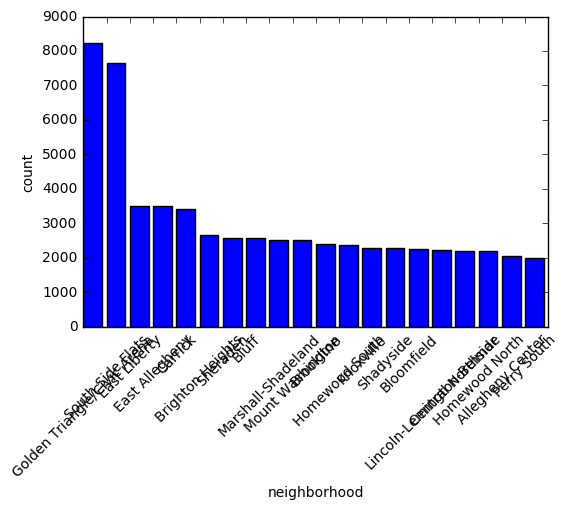

In [17]:
result = _
result.bar()

The graph tells that Golden Triangle and Southside Flats have much higher crime rate than the other area. Therefore we could make a dimension on location, which includes information on the address, neighborhood and zone of the crime happened. 

Another dimension we are interested in is Report, which includes information on report_name, description, section and arrest_time. Such information could help quickly identify the type of crime. 

In [18]:
%%sql
SELECT DISTINCT arrest_time, COUNT(*) as Count
FROM pittscrime
GROUP BY arrest_time
ORDER BY Count DESC
LIMIT 20;

20 rows affected.


arrest_time,count
2016-02-01 10:00:00,86
2016-03-31 11:45:00,65
2016-04-22 19:30:00,55
2016-05-13 13:30:00,45
2015-08-11 16:19:00,39
2015-09-10 17:05:00,38
2016-06-11 05:00:00,36
2016-06-23 18:53:00,35
2016-02-20 19:00:00,34
2015-08-16 17:35:00,34


In [19]:
import matplotlib
%matplotlib inline

<Container object of 20 artists>

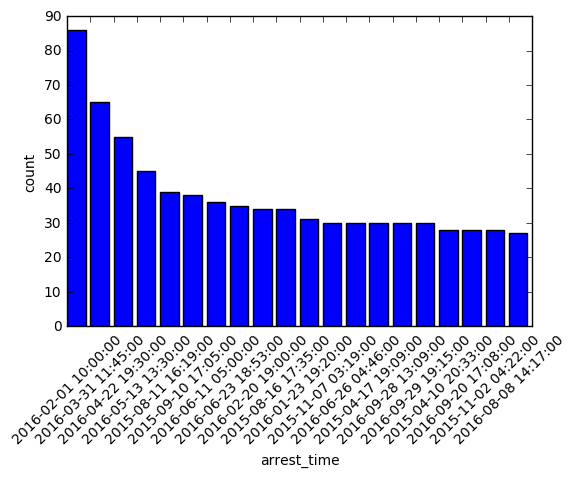

In [20]:
result = _
result.bar()

The above graph show that the top 20 time periods of crime happened. However the column includes a lot of information like year, month, day and exact time. So we'd better to separate all these information for better analysis.

In [21]:
%%sql
DROP TABLE IF EXISTS arrest_day;
CREATE TABLE arrest_day (
    
    day_of_year CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    day_of_week_str CHAR(9),
    day_of_week INTEGER,
    is_weekend BOOLEAN,
    is_weekday BOOLEAN,
    hour_24 INTEGER,
    quarter INTEGER
);

Done.
Done.


[]

In [22]:
%%sql
INSERT INTO arrest_day (day_of_year, year, month, day, day_of_week_str, day_of_week,
                  is_weekend, is_weekday, hour_24, quarter)
SELECT DISTINCT TO_CHAR(arrest_time, 'YYYY-MM-DD') AS day_of_year, 
    CAST(TO_CHAR(arrest_time, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(arrest_time, 'MM') AS INTEGER) AS month,
    CAST(TO_CHAR(arrest_time, 'DD') AS INTEGER) AS day,
    TO_CHAR(arrest_time, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(arrest_time, 'D') AS INTEGER) AS day_of_week,
    CASE WHEN CAST(TO_CHAR(arrest_time, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CASE WHEN CAST(TO_CHAR(arrest_time, 'D') AS INTEGER) NOT IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekday,
    CAST(TO_CHAR(arrest_time, 'HH24') AS INTEGER) AS hour_24,
    CAST(TO_CHAR(arrest_time, 'Q') AS INTEGER) AS quarter
FROM pittscrime;

13718 rows affected.


[]

In [23]:
%%sql
SELECT * FROM arrest_day
LIMIT 10;

10 rows affected.


day_of_year,year,month,day,day_of_week_str,day_of_week,is_weekend,is_weekday,hour_24,quarter
2015-12-23,2015,12,23,Wednesday,4,False,True,14,4
2016-07-03,2016,7,3,Sunday,1,True,False,9,3
2015-07-22,2015,7,22,Wednesday,4,False,True,12,3
2015-07-30,2015,7,30,Thursday,5,False,True,5,3
2015-08-11,2015,8,11,Tuesday,3,False,True,23,3
2015-08-17,2015,8,17,Monday,2,False,True,21,3
2015-09-04,2015,9,4,Friday,6,False,True,9,3
2016-07-01,2016,7,1,Friday,6,False,True,21,3
2015-06-24,2015,6,24,Wednesday,4,False,True,23,2
2015-10-21,2015,10,21,Wednesday,4,False,True,9,4


The above table separates the information included in the "arrest_time" column from tabble "pittscrime" into a new table called "days". We could clearly see the detailed information on the time on each of the crime happened.

## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

We create three dimension tables, which are report_dim,location_dim and arrest_day respectively. The report_dim table includes report_dim_id, report_name, ccr, section, description. The location_dim table contains location_dim_id, neighborhood, zone and address.
The arrest_day dimension table includes arrestday_dim_id, day_of_year, year, month, day, day_of_week_str, day_of_week, is_weekend, is_weekday, hour_24, quarter. Finally, the pittscrime_fact table includes location_dim_id, report_dim_id, report_name, ccr, section, description, neighborhood, zone, arrest_time.

In [24]:
!pwd

/home/jovyan/work


In [25]:
from IPython.display import Image
PATH = "/home/jovyan/work/"

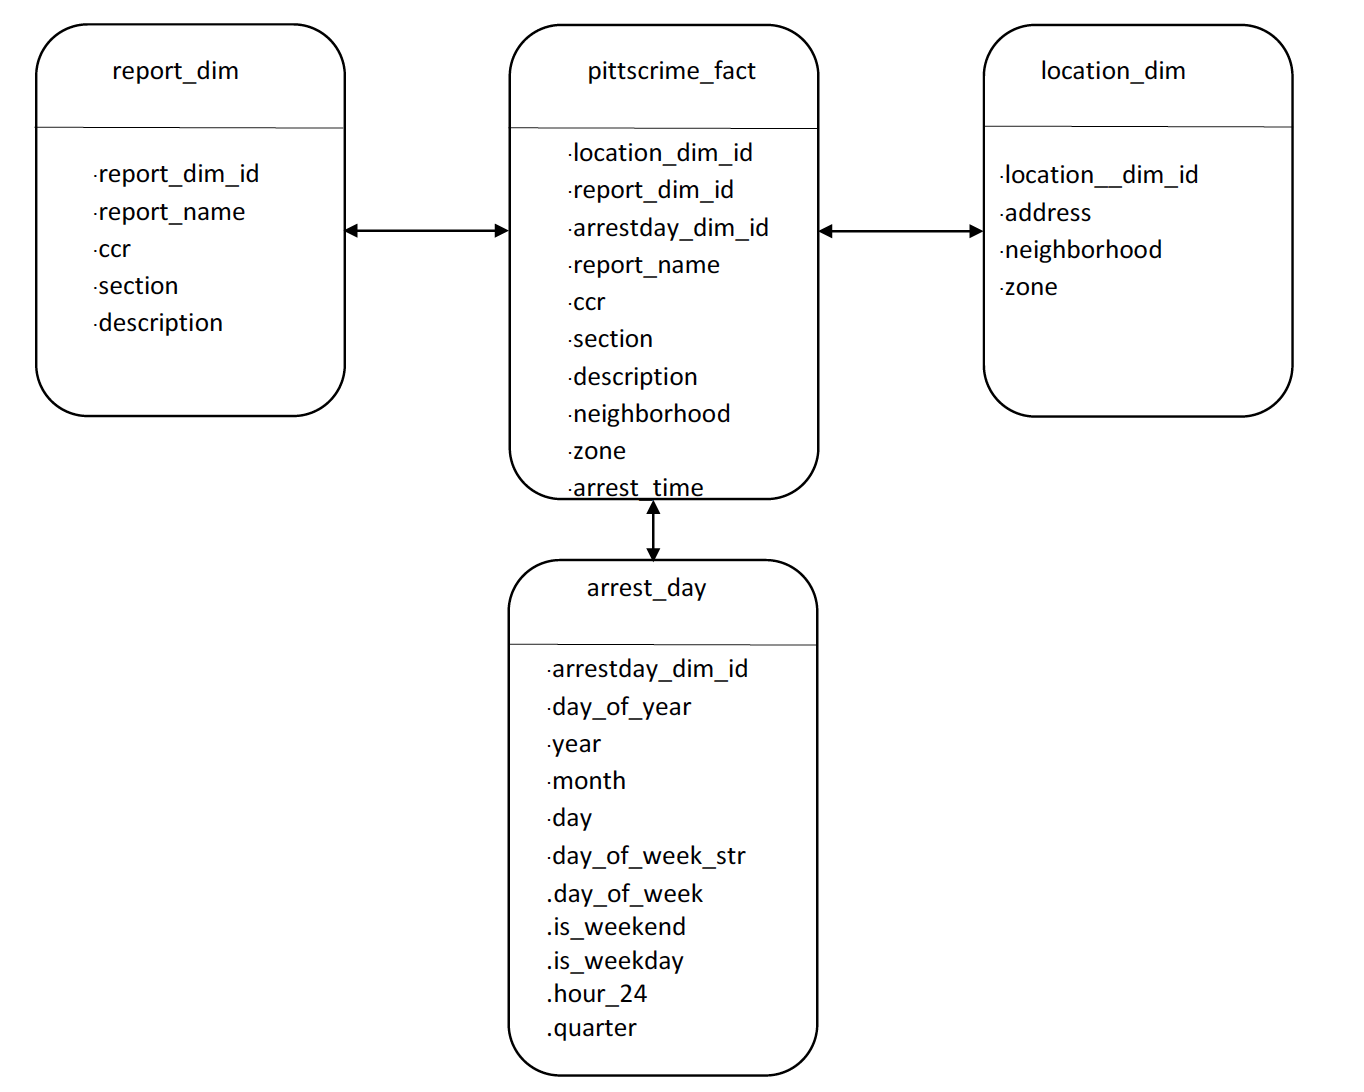

In [27]:
Image(filename = PATH + "starschema.png", width=1000, height=1000)

Add primary key to table "arrest_day" to create the first dimension table "arrest_day".

In [26]:
%%sql
ALTER TABLE arrest_day
ADD COLUMN arrestday_dim_id SERIAL PRIMARY KEY NOT NULL;

Done.


[]

In [27]:
%%sql
SELECT *
FROM arrest_day
LIMIT 10

10 rows affected.


day_of_year,year,month,day,day_of_week_str,day_of_week,is_weekend,is_weekday,hour_24,quarter,arrestday_dim_id
2015-12-23,2015,12,23,Wednesday,4,False,True,14,4,1
2016-07-03,2016,7,3,Sunday,1,True,False,9,3,2
2015-07-22,2015,7,22,Wednesday,4,False,True,12,3,3
2015-07-30,2015,7,30,Thursday,5,False,True,5,3,4
2015-08-11,2015,8,11,Tuesday,3,False,True,23,3,5
2015-08-17,2015,8,17,Monday,2,False,True,21,3,6
2015-09-04,2015,9,4,Friday,6,False,True,9,3,7
2016-07-01,2016,7,1,Friday,6,False,True,21,3,8
2015-06-24,2015,6,24,Wednesday,4,False,True,23,2,9
2015-10-21,2015,10,21,Wednesday,4,False,True,9,4,10


This step is to create a location dimension.

In [28]:
%%sql
DROP TABLE IF EXISTS location_dim;
CREATE TABLE location_dim (
  location_dim_id SERIAL PRIMARY KEY,
  address VARCHAR(53) DEFAULT NULL, 
  neighborhood VARCHAR(27) DEFAULT NULL,
  zone INTEGER DEFAULT NULL  
);

Done.
Done.


[]

In [29]:
%%sql
INSERT INTO location_dim (address,neighborhood,zone)
SELECT ADDRESS,NEIGHBORHOOD,ZONE 
from pittscrime
;

117717 rows affected.


[]

In [30]:
%%sql
SELECT *
FROM location_dim
LIMIT 10;

10 rows affected.


location_dim_id,address,neighborhood,zone
1,400 block East Commons,Allegheny Center,1
2,400 block East Commons,Allegheny Center,1
3,400 block East Commons,Allegheny Center,1
4,27th St,Strip District,2
5,1900 block 5th Ave,Bluff,2
6,100 block Burrows St,Terrace Village,2
7,2200 block Centre Ave,Middle Hill,2
8,1800 block Centre Ave,Crawford-Roberts,2
9,1800 block Centre Ave,Crawford-Roberts,2
10,1800 block Centre Ave,Crawford-Roberts,2


This step is to create a location dimension.

In [31]:
%%sql
DROP TABLE IF EXISTS report_dim;
CREATE TABLE report_dim (
  report_dim_id SERIAL PRIMARY KEY,
  report_name VARCHAR(11) DEFAULT NULL,
  ccr INTEGER DEFAULT NULL,
  section VARCHAR(19) DEFAULT NULL,
  description VARCHAR(128) DEFAULT NULL
);

Done.
Done.


[]

In [32]:
%%sql
INSERT INTO report_dim (report_name, ccr, section,description)
SELECT 
    REPORT_NAME, 
    CCR,
    SECTION,
    DESCRIPTION
from pittscrime
;

117717 rows affected.


[]

In [33]:
%%sql
SELECT *
FROM report_dim
LIMIT 10;

10 rows affected.


report_dim_id,report_name,ccr,section,description
1,OFFENSE 2.0,15158500,903,Criminal Conspiracy.
2,OFFENSE 2.0,15158500,6106,Firearms not to be Carried without a License.
3,OFFENSE 2.0,15158500,3925,Receiving Stolen Property.
4,OFFENSE 2.0,15157796,3502,Burglary.
5,OFFENSE 2.0,15157919,2702,Aggravated Assault.
6,OFFENSE 2.0,15157997,9999,9999 - (Misc. Incident):
7,OFFENSE 2.0,15158116,3304,Criminal Mischief.
8,OFFENSE 2.0,15158026,3928,Unauthorized Use of Automobile and Other Vehicles.
9,ARREST,15158026,3928,Unauthorized Use of Automobile and Other Vehicles.
10,ARREST,15158026,9093,Indirect Criminal Contempt


In [34]:
%%sql
DROP TABLE IF EXISTS pittscrime_fact;
CREATE TABLE pittscrime_fact (
  location_dim_id SERIAL NOT NULL,
  report_dim_id SERIAL NOT NULL,
  arrestday_dim_id SERIAL NOT NULL,
    
  report_name VARCHAR(11) ,
  ccr INTEGER,
  section VARCHAR(19),
  neighborhood VARCHAR(27),
  zone INTEGER,
  arrest_time TIMESTAMP
);

Done.
Done.


[]

In [35]:
%%sql
INSERT INTO pittscrime_fact (report_name,ccr,section,neighborhood,zone,arrest_time)
SELECT report_name,ccr,section,neighborhood,zone,arrest_time
FROM pittscrime
;

117717 rows affected.


[]

In [36]:
%%sql
INSERT INTO pittscrime_fact (arrestday_dim_id)
SELECT arrestday_dim_id
FROM arrest_day
;

13718 rows affected.


[]

In [37]:
%%sql
INSERT INTO pittscrime_fact (location_dim_id)
SELECT location_dim_id
FROM location_dim
;

117717 rows affected.


[]

In [39]:
%%sql
INSERT INTO pittscrime_fact (report_dim_id)
SELECT report_dim_id
FROM report_dim
;

117717 rows affected.


[]

In [40]:
%%sql
UPDATE pittscrime_fact SET report_name = 'Null' where report_name is null;
UPDATE pittscrime_fact SET ccr = -888 where ccr is null;
UPDATE pittscrime_fact SET section = -888 where section is null;
UPDATE pittscrime_fact SET neighborhood = 'Null' where neighborhood is null;
UPDATE pittscrime_fact SET zone = -888 where zone is null;

409992 rows affected.
366869 rows affected.
366869 rows affected.
366870 rows affected.
367413 rows affected.


[]

In [41]:
%%sql
SELECT *
FROM pittscrime_fact
LIMIT 20;

20 rows affected.


location_dim_id,report_dim_id,arrestday_dim_id,report_name,ccr,section,neighborhood,zone,arrest_time
1,1,1,OFFENSE 2.0,15158500,903,Allegheny Center,1,2015-08-22 23:59:00
2,2,2,OFFENSE 2.0,15158500,6106,Allegheny Center,1,2015-08-22 23:59:00
3,3,3,OFFENSE 2.0,15158500,3925,Allegheny Center,1,2015-08-22 23:59:00
4,4,4,OFFENSE 2.0,15157796,3502,Strip District,2,2015-08-22 01:45:00
5,5,5,OFFENSE 2.0,15157919,2702,Bluff,2,2015-08-22 06:00:00
6,6,6,OFFENSE 2.0,15157997,9999,Terrace Village,2,2015-08-22 10:15:00
7,7,7,OFFENSE 2.0,15158116,3304,Middle Hill,2,2015-08-22 11:00:00
8,8,8,OFFENSE 2.0,15158026,3928,Crawford-Roberts,2,2015-08-22 11:11:00
9,9,9,ARREST,15158026,3928,Crawford-Roberts,2,2015-08-22 11:15:00
10,10,10,ARREST,15158026,9093,Crawford-Roberts,2,2015-08-22 11:15:00


## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

So let's first have a detailed look of the fact table.

In [42]:
%%sql
SELECT column_name, data_type, character_maximum_length, is_nullable
FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'pittscrime_fact';

9 rows affected.


column_name,data_type,character_maximum_length,is_nullable
location_dim_id,integer,None,NO
report_dim_id,integer,None,NO
arrestday_dim_id,integer,None,NO
report_name,character varying,11,YES
ccr,integer,None,YES
section,character varying,19,YES
neighborhood,character varying,27,YES
zone,integer,None,YES
arrest_time,timestamp without time zone,None,YES


The above table tells the information about column name, data type, character length and whether the column has null value. So that we can ensure from the table that our three foreign key columns(location_dim_id, report_dim_id & arrestday_dim_id) contain no null value.

So can we filter the fact table by the arrest_day dimension table?

In [43]:
%%sql
SELECT COUNT(*), day_of_week_str
from pittscrime_fact a join arrest_day d on a.arrestday_dim_id = d.arrestday_dim_id
group by day_of_week_str
order by CASE day_of_week_str
    WHEN 'Sunday' THEN 1
    WHEN 'Monday' THEN 2
    WHEN 'Tuesday' THEN 3
    WHEN 'Wednesday' THEN 4
    WHEN 'Thursday' THEN 5
    WHEN 'Friday' THEN 6
    ELSE 7
END
;

7 rows affected.


count,day_of_week_str
3872,Sunday
3972,Monday
3920,Tuesday
3938,Wednesday
3940,Thursday
3872,Friday
3922,Saturday


In [44]:
%matplotlib inline

<Container object of 7 artists>

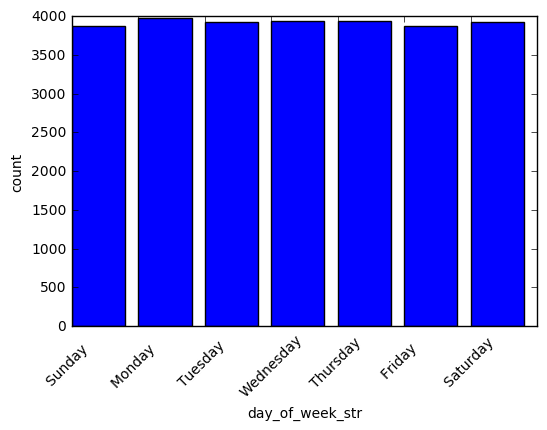

In [45]:
result = _
result.bar()

From the bar graph we could tell that the crime rate of every day is almost the same.

In [46]:
%%sql
SELECT quarter, COUNT(quarter)
from pittscrime_fact a join arrest_day d on a.arrestday_dim_id = d.arrestday_dim_id
group by quarter
order by quarter DESC

4 rows affected.


quarter,count
4,5804
3,8434
2,8106
1,5092


In [47]:
%matplotlib inline

<Container object of 4 artists>

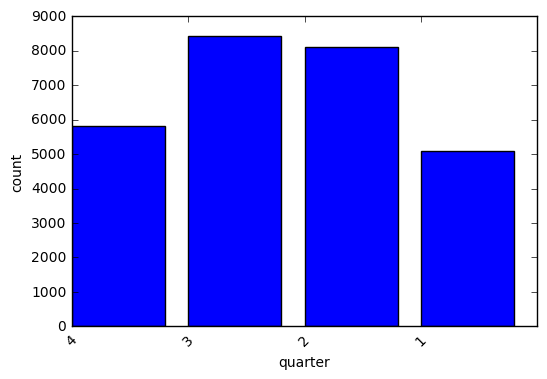

In [48]:
result = _
result.bar()

By filtering the quarter crime rate, we can tell that in general the second and third quarters have the highest crime rate. 

We want to know which neighborhood has most crimes. Then we can use the foreigh key in the location_dim table.

In [49]:
%%sql
SELECT l.neighborhood, COUNT(*) 
FROM location_dim l, pittscrime_fact p
WHERE l.location_dim_id = p.location_dim_id
GROUP BY l.neighborhood
ORDER BY COUNT DESC
LIMIT 5;

5 rows affected.


neighborhood,count
Golden Triangle/Civic Arena,16458
South Side Flats,15290
East Liberty,7006
East Allegheny,6998
Carrick,6804


<Container object of 5 artists>

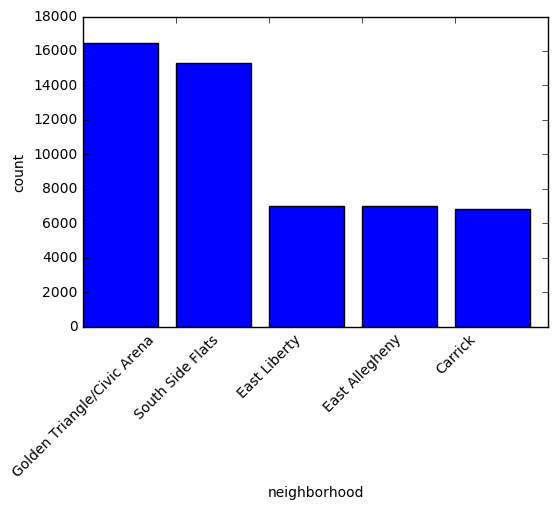

In [50]:
%matplotlib inline
result = _
result.bar()

Again we want to know which zone accounts for the most number of crimes and from the pie chart we find that zone 1 has most crimes.

In [51]:
%%sql
SELECT l.zone, COUNT(*) 
FROM location_dim l, pittscrime_fact p
WHERE l.location_dim_id = p.location_dim_id
GROUP BY l.zone
ORDER BY COUNT DESC
LIMIT 6;

6 rows affected.


zone,count
1,52216
3,48312
5,41228
2,38812
4,28420
6,25358


([<matplotlib.patches.Wedge at 0x7f0af2b3b160>,
  <matplotlib.text.Text at 0x7f0af2ad3780>])

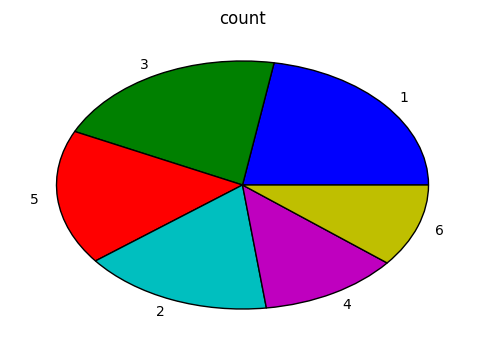

In [52]:
%matplotlib inline
result = _
result.pie()

The above pie tells us Zone 1 and Zone 3 have the higest crime rate.

So the next question is that can we use the location_dim_id foreign key to narrow down the area and its crime rate?

In [53]:
%%sql
SELECT l.zone, COUNT(l.zone) as zone_count, l.neighborhood, COUNT(l.neighborhood) as neighborhood_count
FROM location_dim l, pittscrime_fact p
WHERE l.location_dim_id = p.location_dim_id
GROUP BY l.zone, l.neighborhood
ORDER BY COUNT(l.zone) DESC
LIMIT 6;

6 rows affected.


zone,zone_count,neighborhood,neighborhood_count
3,15218,South Side Flats,15218
2,14702,Golden Triangle/Civic Arena,14702
1,6874,East Allegheny,6874
3,6774,Carrick,6774
5,6770,East Liberty,6770
1,5196,Brighton Heights,5196


The above table show the crime rate associated with combined zone and neighborhood. Because several zones can belong to the same neighborhood and one neighborhood can also overlap with several zones. The filters used here are both "zone" and "neighborhood" so that we can narrow down the area with the most crime rate. Because from the filtered result we could say a neighboehood could contain several zones and one zone could belong to several neighborhoods as well. The most dangerous area in Pittsburgh is Neighborhood "South Side Flats" at Zone 3.

## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.

In [54]:
!wget https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f

--2016-11-27 03:33:05--  https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f
Resolving data.wprdc.org (data.wprdc.org)... 136.142.88.59
Connecting to data.wprdc.org (data.wprdc.org)|136.142.88.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738257 (721K) [text/csv]
Saving to: ‘e03a89dd-134a-4ee8-a2bd-62c40aeebc6f’

e03a89dd-134a-4ee8- 100%[=====================>] 720.95K  --.-KB/s   in 0.05s  

2016-11-27 03:33:05 (13.1 MB/s) - ‘e03a89dd-134a-4ee8-a2bd-62c40aeebc6f’ saved [738257/738257]



We find another external data about arrested criminals in Pittsburgh. We are curious about how age, gender, race, public_works_division affect crimes.

In [55]:
!mv -n e03a89dd-134a-4ee8-a2bd-62c40aeebc6f arrest.csv

In [56]:
!csvcut -n arrest.csv

  1: _id
  2: PK
  3: CCR
  4: AGE
  5: GENDER
  6: RACE
  7: ARRESTTIME
  8: ARRESTLOCATION
  9: OFFENSES
 10: INCIDENTLOCATION
 11: INCIDENTNEIGHBORHOOD
 12: INCIDENTZONE
 13: INCIDENTTRACT
 14: COUNCIL_DISTRICT
 15: PUBLIC_WORKS_DIVISION
 16: X
 17: Y


In [57]:
!wc -l arrest.csv

2526 arrest.csv


In [58]:
!head arrest.csv|csvlook

|-------+---------+----------+-----+--------+------+---------------------+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------+----------------------+--------------+---------------+------------------+-----------------------+-------------------+-------------------|
|  _id  | PK      | CCR      | AGE | GENDER | RACE | ARRESTTIME          | ARRESTLOCATION                                           | OFFENSES                                                                                                                                                       | INCIDENTLOCATION                                         | INCIDENTNEIGHBORHOOD | INCIDENTZONE | INCIDENTTRACT | COUNCIL_DISTRICT | PUBLIC_WORKS_DIVISION | X                 | Y                 |
|-------+---------

In [59]:
!createdb -U dbuser arrest

In [60]:
%sql postgresql://dbuser@localhost:5432/arrest

'Connected: dbuser@arrest'

In [61]:
!csvsql --db sqlite:///arrest.db --insert arrest.csv

In [62]:
%%sql
DROP TABLE IF EXISTS arrest;
CREATE TABLE arrest
(
    id INTEGER,
    PK INTEGER,
    CCR INTEGER,
    AGE INTEGER, 
    GENDER VARCHAR(4),
    RACE VARCHAR(1),
    ARREST_TIME TIMESTAMP,
    ARRESTLOCATION VARCHAR(64),
    OFFENSES VARCHAR(629),
    INCIDENTLOCATION VARCHAR(68),
    INCIDENTNEIGHBORHOOD VARCHAR(27),
    INCIDENTZONE VARCHAR(3),
    INCIDENTTRACT INTEGER,
    COUNCIL_DISTRICT INTEGER,
    PUBLIC_WORKS_DIVISION INTEGER,
    X FLOAT, 
    Y FLOAT
)

Done.
Done.


[]

In [63]:
%%sql
COPY arrest FROM '/home/jovyan/work/arrest.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

2525 rows affected.


[]

In [64]:
%%sql
SELECT COUNT(*)
FROM arrest;

1 rows affected.


count
2525


In [65]:
%%sql
SELECT *
FROM arrest
LIMIT 10;

10 rows affected.


id,pk,ccr,age,gender,race,arrest_time,arrestlocation,offenses,incidentlocation,incidentneighborhood,incidentzone,incidenttract,council_district,public_works_division,x,y
4,1974550,16145257,25,F,W,2016-08-05 02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunkenness,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304,1,1,-80.0019387579446,40.454080431959
1713,1976626,16186051,29,M,B,2016-10-02 04:11:00,"4600 Block Browns Hill RD Pittsburgh, PA 15217",9093 Indirect Criminal Contempt,"4600 Block Browns Hill RD Pittsburgh, PA 15217",Squirrel Hill South,4,1414,5,3,-79.9249410972177,40.4155942417593
1902,1976884,16194344,36,M,B,2016-10-14 15:34:00,"100 Block Broad ST & N Whitfield ST Pittsburgh, PA 15206",4910 Tampering with or Fabricating Physical Evidence. / 13(a)(32) Paraphernalia - Use or Possession / 4914 False Identification to Law Enforcement Authorities,"100 Block Broad ST & N Whitfield ST Pittsburgh, PA 15206",East Liberty,5,1115,None,None,0.0,0.0
5,1974596,16145962,25,M,B,2016-08-06 02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Endangering Another Person. / 3925 Receiving Stolen Property. / 4304(a)(1) Endangering Welfare of Children.,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814,2,5,-80.0522041374568,40.4458998235053
14,1974578,16144432,27,M,W,2016-08-13 15:43:00,"1300 Block E Carson ST Pittsburgh, PA 15203",3921(a) Theft by Unlawful Taking or Disposition - Movable item,"1000 Block Lessing ST Pittsburgh, PA 15205",Crafton Heights,6,2814,2,5,-80.0496857912552,40.4439178364361
19,1975192,16150754,33,M,W,2016-08-12 21:07:00,"1500 Block Milan AV Pittsburgh, PA 15226",9501 Bench Warrant,"1500 Block Milan AV Pittsburgh, PA 15226",Brookline,6,3206,4,4,-80.0058032356292,40.3938682477685
1005,1975718,16166519,22,M,A,2016-09-06 16:44:00,"600 Block 1st AV Pittsburgh, PA 15219",493(1) Furnishing Liquor/Malt to Intox.Persons/Minors.Etc. / 6310.1 Selling Liquor to Minors / 601.19 Social Host and Underage Drinking,"300 Block Atwood ST Pittsburgh, PA 15213",Central Oakland,4,405,3,3,-79.9559451409605,40.4395175941235
1503,1976375,16180874,20,F,B,2016-09-24 14:00:00,"Beaver AV & Pennsylvania AV Pittsburgh, PA 15233",903 Criminal Conspiracy. / 3502 Burglary. / 3701 Robbery.,"10 Block Mitchell ST Pittsburgh, PA 15212",Marshall-Shadeland,1,2715,1,1,-80.0298621150587,40.4770183009667
2401,1977545,16204926,28,M,B,2016-10-30 22:00:00,"1100 Block Buente ST Pittsburgh, PA 15212",903 Criminal Conspiracy. / 2901 Kidnapping. / 2902 Unlawful Restraint. / 2903 False Imprisonment. / 3701 Robbery.,"300 Block S Main ST Pittsburgh, PA 15220",West End,6,2019,7,2,-79.9579443641231,40.4673750344012
1903,1976885,16194377,21,M,W,2016-10-14 16:35:00,"Henderson ST & Sandusky CT Pittsburgh, PA 15212",4910 Tampering with or Fabricating Physical Evidence. / 13(a)(16) Possession of Controlled Substance / 3503(b)(1)(ii) Defiant Trespass Notice Posted by Sign(s),"Henderson ST & Sandusky CT Pittsburgh, PA 15212",Fineview,1,2509,6,1,-80.0056236909827,40.4592271304641


In [66]:
%%sql
DROP TABLE IF EXISTS person_dim;
CREATE TABLE person_dim (
  person_dim_id SERIAL PRIMARY KEY,
  age INTEGER, 
  gender VARCHAR(4) DEFAULT NULL,
  race VARCHAR(1) DEFAULT NULL,
  public_works_division INTEGER
);

Done.
Done.


[]

In [67]:
%%sql
INSERT INTO person_dim (age, gender, race, public_works_division)
SELECT 
    age, 
    gender,
    race,
    public_works_division
FROM arrest
;

2525 rows affected.


[]

In [68]:
%%sql
SELECT * 
FROM person_dim
LIMIT 10;

10 rows affected.


person_dim_id,age,gender,race,public_works_division
1,25,F,W,1
2,29,M,B,3
3,36,M,B,None
4,25,M,B,5
5,27,M,W,5
6,33,M,W,4
7,22,M,A,3
8,20,F,B,1
9,28,M,B,2
10,21,M,W,1


The above is the new dimension table we created which includes detailed personal information about the criminal is Pittsburgh area. These information are useful supplement to our existing star schema. 

Xinyi LU and Boer FENG do each part together and we all contribute significantly to this project.